In [106]:
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from autogluon.tabular import TabularPredictor
from sklearn.model_selection import train_test_split

import numpy as np
import tensorflow as tf
from sklearn.model_selection import KFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

<h1>Hyperparameters<h1>


In [107]:
#Add here

<h1>Creating DataFrames<h1>

In [108]:
spot_prices = pd.read_csv("spotpriser.csv").set_index("time")
consumption = pd.read_csv("consumption_temp_with_flags.csv").set_index("time")

oslo_consumption = consumption[consumption["location"] == "oslo"]
oslo_consumption = oslo_consumption.merge(spot_prices["oslo"], left_index=True, right_index=True, how="left")
oslo_consumption=oslo_consumption.drop(['location'],axis=1).rename(columns={'oslo':'spot_price'})

stavanger_consumption = consumption[consumption["location"] == "stavanger"]
stavanger_consumption = stavanger_consumption.merge(spot_prices["stavanger"], left_index=True, right_index=True, how="left")
stavanger_consumption=stavanger_consumption.drop(['location'],axis=1).rename(columns={'stavanger':'spot_price'})

trondheim_consumption = consumption[consumption["location"] == "trondheim"]
trondheim_consumption = trondheim_consumption.merge(spot_prices["trondheim"], left_index=True, right_index=True, how="left")
trondheim_consumption=trondheim_consumption.drop(['location'],axis=1).rename(columns={'trondheim':'spot_price'})

tromso_consumption = consumption[consumption["location"] == "tromsø"]
tromso_consumption = tromso_consumption.merge(spot_prices["tromsø"], left_index=True, right_index=True, how="left")
tromso_consumption=tromso_consumption.drop(['location'],axis=1).rename(columns={'tromsø':'spot_price'})

bergen_consumption = consumption[consumption["location"] == "bergen"]
bergen_consumption = bergen_consumption.merge(spot_prices["bergen"], left_index=True, right_index=True, how="left")
bergen_consumption=bergen_consumption.drop(['location'],axis=1).rename(columns={'bergen':'spot_price'})


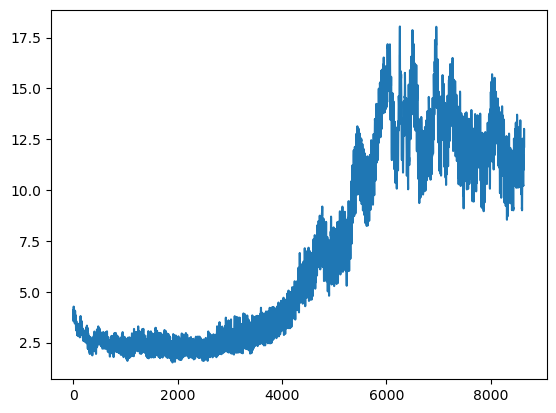

In [109]:
plot_df = oslo_consumption.reset_index()
plt.plot(plot_df['consumption'])

<h1>Feature engineering<h1>

In [110]:
CONSUMPTION_DFS = [oslo_consumption,stavanger_consumption,trondheim_consumption,tromso_consumption,bergen_consumption]

cols_to_standard_normal = ["temperature","delta_temp"]
cols_to_normalize_01 = ["consumption","spot_price"]

for df in CONSUMPTION_DFS:
    df["delta_temp"] = df["temperature"]-df["temperature"].shift(1)
    df["is_holiday"] = df["is_holiday"].astype(int)
    df["is_weekend"] = df["is_weekend"].astype(int)

    for col in cols_to_standard_normal:
        mu, sig = df[col].mean(), df[col].std()
        df[col] = (df[col]-mu)/sig
    for col in cols_to_normalize_01:
        df[col] = (df[col]-df[col].min())/(df[col].max()-df[col].min())
    df = df.iloc[1:,:]


<h1>Splitting datasets<h1>

In [111]:
oslo_with_price = oslo_consumption.dropna()
oslo_no_price = pd.concat([oslo_consumption,oslo_with_price]).drop_duplicates(keep=False).drop(columns=["spot_price"])

stavanger_with_price = stavanger_consumption.dropna()
stavanger_no_price = pd.concat([stavanger_consumption,stavanger_with_price]).drop_duplicates(keep=False).drop(columns=["spot_price"])

trondheim_with_price = trondheim_consumption.dropna()
trondheim_no_price = pd.concat([trondheim_consumption,trondheim_with_price]).drop_duplicates(keep=False).drop(columns=["spot_price"])

tromso_with_price = tromso_consumption.dropna()
tromso_no_price = pd.concat([tromso_consumption,tromso_with_price]).drop_duplicates(keep=False).drop(columns=["spot_price"])

bergen_with_price = bergen_consumption.dropna()
bergen_no_price = pd.concat([bergen_consumption,bergen_with_price]).drop_duplicates(keep=False).drop(columns=["spot_price"])



In [112]:
oslo_with_price

,consumption,temperature,is_holiday,is_weekend,spot_price,delta_temp
time,,,,,,
2022-04-07 22:00:00,0.139039,-0.797312,0,0,0.209401,-0.653485
2022-04-07 23:00:00,0.129531,-0.808714,0,0,0.209193,-0.108693
2022-04-08 00:00:00,0.124876,-0.820116,0,0,0.206737,-0.108693
2022-04-08 01:00:00,0.122786,-0.797312,0,0,0.205474,0.218181
2022-04-08 02:00:00,0.122980,-0.842920,0,0,0.203956,-0.435568
...,...,...,...,...,...,...
2023-04-02 17:00:00,0.659003,-0.215810,0,1,0.131512,-1.525151
2023-04-02 18:00:00,0.686003,-0.295624,0,1,0.140193,-0.762443
2023-04-02 19:00:00,0.695320,-0.774508,0,1,0.150793,-4.575982


In [113]:
ALL_DFS = [oslo_with_price,oslo_no_price,stavanger_with_price,stavanger_no_price,trondheim_with_price,trondheim_no_price,tromso_with_price,tromso_no_price,bergen_with_price,bergen_no_price]

for i in range(len(ALL_DFS)):
    ALL_DFS[i].index = pd.to_datetime(ALL_DFS[i].index)
    ALL_DFS[i]["hour"] = ALL_DFS[i].index.hour

/var/folders/qq/swkbps694sxgbbm7j_cjk0mr0000gn/T/ipykernel_52125/2434831662.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ALL_DFS[i]["hour"] = ALL_DFS[i].index.hour
/var/folders/qq/swkbps694sxgbbm7j_cjk0mr0000gn/T/ipykernel_52125/2434831662.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ALL_DFS[i]["hour"] = ALL_DFS[i].index.hour
/var/folders/qq/swkbps694sxgbbm7j_cjk0mr0000gn/T/ipykernel_52125/2434831662.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFra

<h1>Making training data<h1>

MAPE LSTM: 19.366832691101035%


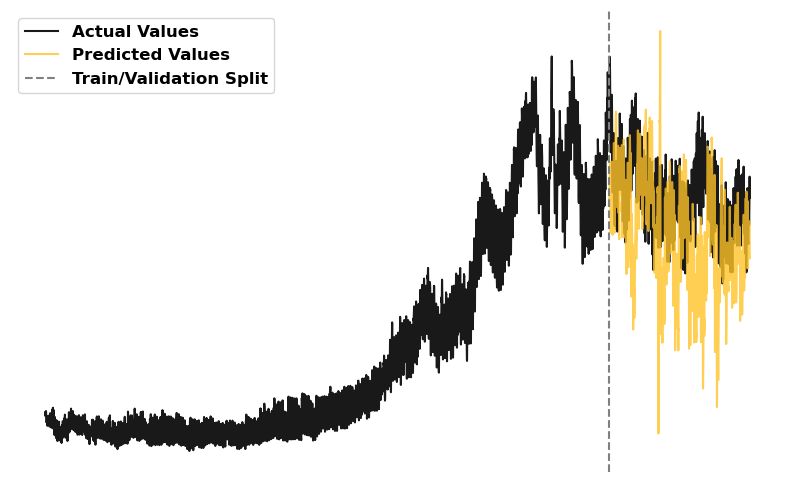

In [128]:
# Seed for reproducibility
np.random.seed(0)

# Function to create dataset with lags for multiple variables
def create_multivariate_dataset(data, min_lag=1, max_lag=3):
    X, y = [], []
    for i in range(max_lag, len(data)):
        lagged_data = data.iloc[i-max_lag:i-min_lag+1, 1:]  # Shape: [time_steps, num_predictors]
        X.append(lagged_data.values)
        y.append(data.iloc[i, 0])  # Target variable (Sales)
    return np.array(X), np.array(y)

"""# Hyperparameter ranges
min_lag_values = [120]
max_lag_values = [2120]
lstm_units_values = [25]

# k-Fold for validation
k = 5
kf = KFold(n_splits=k, shuffle=False)

# Grid Search
best_mape = float('inf')
best_hyperparams = None

print("Min Max Units || MAPE")
for min_lag in min_lag_values:
    for max_lag in max_lag_values:
        for lstm_units in lstm_units_values:
            if max_lag > min_lag:
                print(f"{min_lag}   {max_lag}   {lstm_units}   ||",end="")
                X, y = create_multivariate_dataset(data, min_lag, max_lag)
                mape_values = []

                for train_index, val_index in kf.split(X):
                    X_train, X_val = X[train_index], X[val_index]
                    y_train, y_val = y[train_index], y[val_index]

                    # Building and Training the LSTM Model
                    model = Sequential()
                    model.add(LSTM(lstm_units, activation='relu', input_shape=(X.shape[1], X.shape[2])))
                    model.add(Dense(1))
                    model.compile(optimizer='adam', loss='mse')

                    # Training the model
                    model.fit(X_train, y_train, epochs=5, verbose=0)

                    # Making predictions
                    y_pred = model.predict(X_val, verbose=0).flatten()

                    # Calculating MAPE for the fold
                    mape = np.mean(np.abs((y_val - y_pred) / y_val)) * 100
                    mape_values.append(mape)

                # Averaging MAPE across all folds
                average_mape = np.mean(mape_values)
                print(f" {average_mape}")
                # Update best hyperparameters if current MAPE is lower
                if best_hyperparams == None:
                    best_hyperparams = (min_lag, max_lag, lstm_units)
                if best_mape == float('inf'):
                    best_mape = average_mape
                if average_mape < best_mape:
                    best_mape = average_mape
                    best_hyperparams = (min_lag, max_lag, lstm_units)

print(f'Best Hyperparameters: min_lag={best_hyperparams[0]}, max_lag={best_hyperparams[1]}, LSTM Units={best_hyperparams[2]}')
print(f'Best MAPE: {best_mape}%')
"""
data=oslo_with_price
X, y = create_multivariate_dataset(data, 120, 168)
k=5
kf = KFold(n_splits=k, shuffle=False)

for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    # Building and Training the LSTM Model with best hyperparameters
    model = Sequential()
    #model.add(LSTM(best_hyperparams[2], activation='relu', input_shape=(X.shape[1], X.shape[2])))
    model.add(LSTM(25, activation='relu', input_shape=(X.shape[1], X.shape[2])))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')

    # Training the model
    model.fit(X_train, y_train, epochs=5, verbose=0)

    # Making predictions
    y_pred = model.predict(X_val, verbose=0).flatten()
    train_pred = model.predict(X_train, verbose=0).flatten()

mape = np.mean(np.abs((y_val - y_pred) / y_val)) * 100
print(f'MAPE LSTM: {mape}%')

 # Create an array of indices for plotting
xs = range(len(y))
xs_train = range(len(train_pred))
xs_oos = range(len(train_pred),len(train_pred)+len(y_pred))

# Plot actual values and predictions
plt.figure(figsize=(10, 6))
plt.plot(xs, y, label='Actual Values', color='black', alpha=0.9)
#plt.plot(xs_train, train_pred, label='In-sample Predictions', color='green',alpha=0.2)
plt.plot(xs_oos, y_pred, label='Predicted Values', color='#FFC328', alpha=0.8)
plt.axvline(len(train_pred), linestyle='--', color='gray', label='Train/Validation Split')
#plt.title(f"LSTM Predictions vs Actual Values - Oslo")
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
#plt.xlabel('Time')
plt.xticks([])
plt.yticks([])
#plt.ylabel('Values')
plt.legend(fontsize=14)
legend = plt.legend(fontsize='12')
for text in legend.get_texts():
    text.set_fontweight('bold')
plt.show()

Baseline MAPE for Oslo: 19.49%


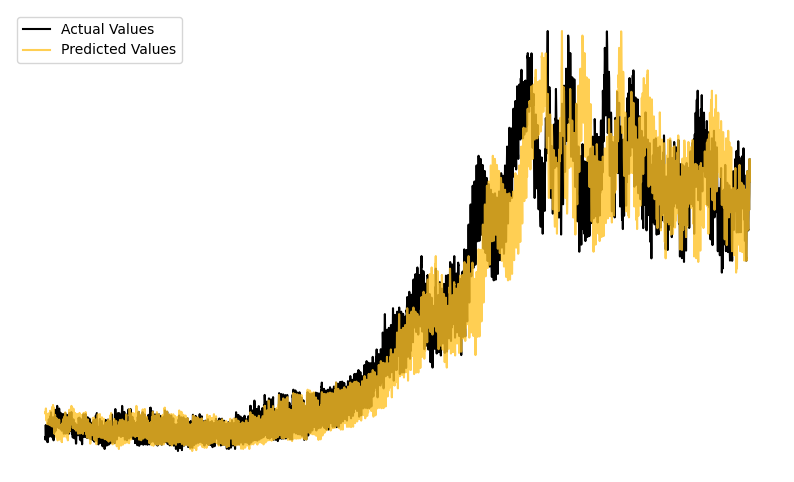

Baseline MAPE for Stavanger: 21.56%


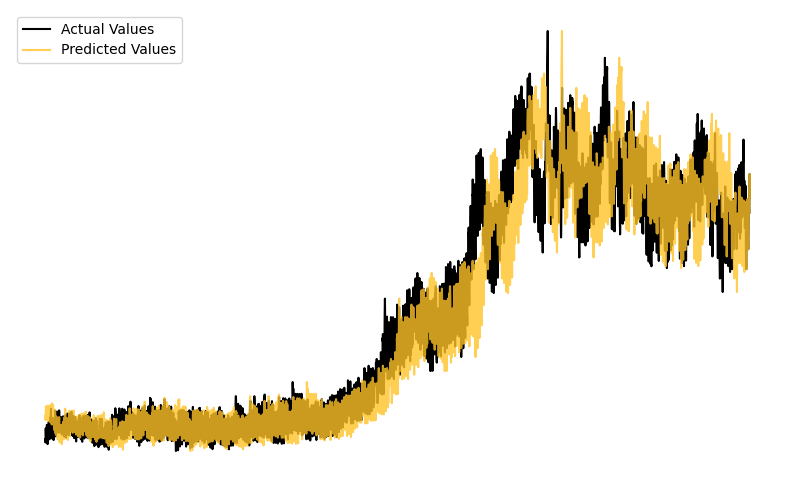

Baseline MAPE for Trondheim: 21.33%


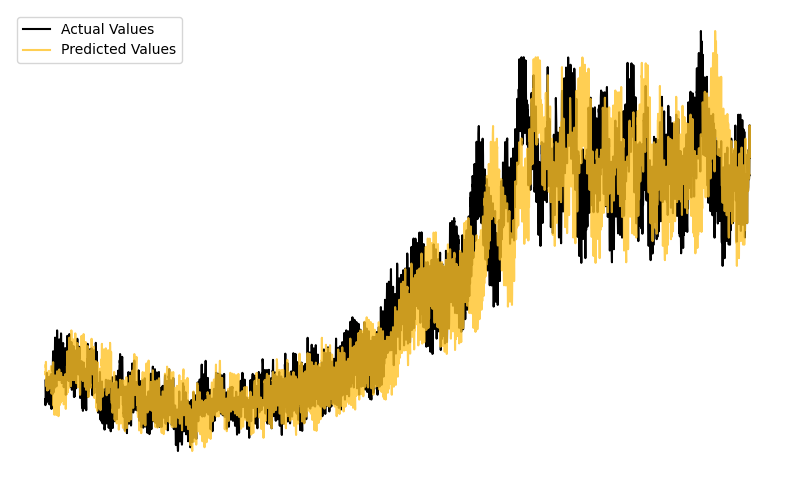

Baseline MAPE for Tromsø: 22.66%


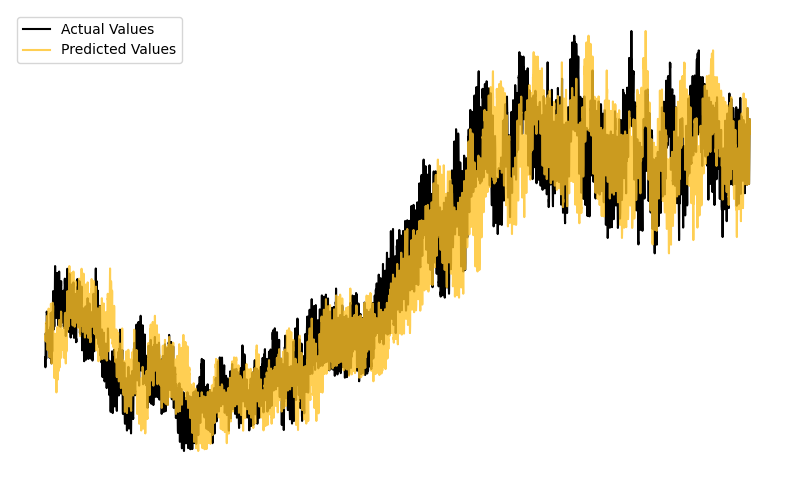

Baseline MAPE for Bergen: 23.29%


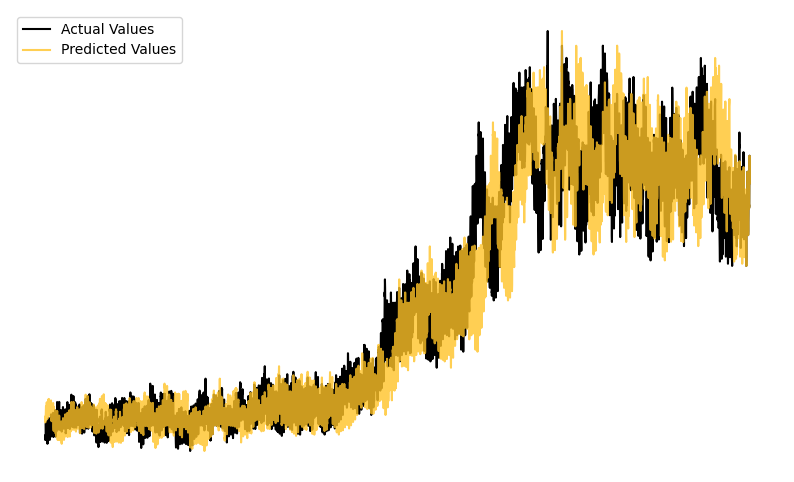

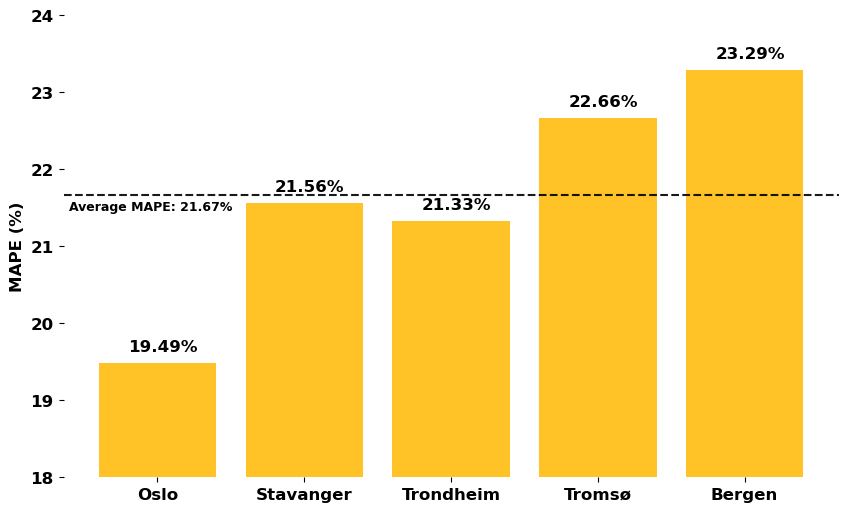

In [116]:
# Function to create a simple baseline model
def baseline_model(y, min_lag):
    baseline_predictions = []
    baseline_predictions = y[:-min_lag]
    actual = y[min_lag:]
    mask = actual != 0
    baseline_mape = np.mean(np.abs((actual[mask] - baseline_predictions[mask]) / actual[mask])) * 100
    return baseline_predictions, baseline_mape, actual

# Function to create dataset with lags for multiple variables
def create_multivariate_dataset(data, min_lag=1, max_lag=3):
    X, y = [], []
    for i in range(max_lag, len(data)):
        lagged_data = data.iloc[i-max_lag:i-min_lag+1, 1:] 
        X.append(lagged_data.values)
        y.append(data.iloc[i, 0]) 
    return np.array(X), np.array(y)

data = []
data.append(oslo_with_price)
data.append(stavanger_with_price)
data.append(trondheim_with_price)
data.append(tromso_with_price)
data.append(bergen_with_price)
city = ["Oslo", "Stavanger", "Trondheim", "Tromsø", "Bergen"]

mape_values = []

for i in range(5):
    # Calculate the baseline predictions
    min_lag = 168
    max_lag = 169
    X, y = create_multivariate_dataset(data[i], min_lag, max_lag)
    baseline_predictions, baseline_mape, actual = baseline_model(y,min_lag) 
    mape_values.append(baseline_mape)
    print(f'Baseline MAPE for {city[i]}: {baseline_mape:.2f}%')


    # Plot the predictions against the actual values
    plt.figure(figsize=(10, 6))
    plt.plot(actual, label='Actual Values', color='black')
    plt.plot(baseline_predictions, label='Predicted Values', color='#FFC328',alpha=0.8)
    #plt.title(f'Baseline Model Predictions vs Actual Values - {city[i]}', fontweight='bold')
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['bottom'].set_visible(False)
    plt.gca().spines['left'].set_visible(False)
    #plt.xlabel('Time', fontweight='bold')
    plt.xticks([])
    plt.yticks([])
    #plt.ylabel('Values', fontweight='bold')
    #plt.legend()
    plt.show()


average_mape = np.mean(mape_values)

# Plot the MAPE values in a bar chart
plt.figure(figsize=(10, 6))
bars_mape = plt.bar(city, mape_values, color='#FFC328', label='MAPE')
#plt.title('Baseline Model MAPE for Different Cities', fontweight='bold')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
#plt.xlabel('City')
plt.xticks(fontweight='bold', fontsize=12)
plt.yticks(fontweight='bold', fontsize=12)
plt.ylabel('MAPE (%)', fontsize=12, fontweight='bold')
plt.ylim(18, 24)
for i, (bar, value) in enumerate(zip(bars_mape, mape_values)):
    plt.text(bar.get_x() + bar.get_width() / 2 - 0.2, bar.get_height() + 0.15, f'{value:.2f}%', fontweight='bold', fontsize=12)

plt.axhline(y=average_mape, color='black', alpha=0.9, linestyle='--', label=f'Average MAPE: {average_mape:.2f}%')
plt.text(-0.6, average_mape - 0.2, f'Average MAPE: {average_mape:.2f}%', color='black', fontweight='bold', fontsize=9)
#plt.legend()
plt.show()